In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [177]:
np.__version__

'1.23.5'

In [2]:
df = pd.read_csv('data/data_19.csv')
df = df.drop_duplicates()
df = df[df['stadsdeel']!='Weesp']
df['price_per_m2'] = df['price']/df['surface']
df['price_per_room'] = df['price']/df['rooms']

In [33]:
subdivision_stadsdeel_map = df[['stadsdeel','stadsdeel_onderverdeling']].drop_duplicates().set_index('stadsdeel_onderverdeling').to_dict('index')
subdivion_stadsdeel_map = {s : subdivision_stadsdeel_map[s]['stadsdeel'] for s in subdivision_stadsdeel_map }

In [105]:
property_type_map = {
    'Appartement': 'Apartment',
    'Flat': 'Apartment',
    'Studio': 'Apartment',
    'House': 'House',
    'Huis': 'House',
    'Room': 'Room'
}
df['property_type'] = df['property_type'].map(property_type_map)

In [175]:
df = df.copy()

In [109]:
furnished_map = {
    'Upholstered': 'Upholstered',
    'Furnished': 'Furnished',
    'Upholstered or furnished': 'Furnished',
    'Shell': 'Shell'
}
df.loc[df['post_type']=='Rent', 'furnished'] = df.loc[df['post_type']=='Rent', 'furnished'].map(furnished_map)

In [36]:
percentile_lower = 0.01
percentile_upper = 0.99
percentile_bounds = [percentile_lower, percentile_upper]
stadsdeel_order = ['Stadsdeel Centrum', 'Stadsdeel West', 
                   'Stadsdeel Oost', 'Stadsdeel Zuid',
                   'Stadsdeel Noord', 'Stadsdeel Nieuw-West', 
                   'Stadsdeel Zuidoost']

In [67]:
def remove_outliers(df, column_name, percentile_bounds):
    processed_df = df.copy()
    lower_bound = processed_df[column_name].quantile(percentile_bounds[0])
    upper_bound = processed_df[column_name].quantile(percentile_bounds[1])
    processed_df = processed_df[(
        (processed_df[column_name] >= lower_bound)&
        (processed_df[column_name] <= upper_bound)
    )]
    return processed_df
    

In [159]:
def compute_statistics(df, column_name, post_type, property_type, furnished, region_resolution, percentile_bounds):
    stats = []
    df_s = df.copy()
    df_s[f'log_{column_name}'] = np.log(df_s[column_name])
    if property_type != 'All':
        df_s = df_s[df_s['property_type'] == property_type]
    if post_type == 'Rent':
        if furnished != 'All':
            df_s = df_s[df_s['furnished']==furnished]
    for region in df[region_resolution].unique():
        if region_resolution == 'stadsdeel':
            stadsdeel = region
            subdivision = None
        elif region_resolution == 'stadsdeel_onderverdeling':
            stadsdeel = subdivion_stadsdeel_map[region]
            subdivision = region
        df_r = df_s[df_s[region_resolution]==region]
        property_count = len(df_r)
        if property_count < 10:
            continue
        
        processed_df = remove_outliers(df_r, f'log_{column_name}', percentile_bounds)
        
        median = processed_df[column_name].median()
        q1 = processed_df[column_name].quantile(0.25)
        q3 = processed_df[column_name].quantile(0.75)
        mode = processed_df[column_name].mode().iloc[0]
        log_mean = processed_df[f'log_{column_name}'].mean()
        log_std = processed_df[f'log_{column_name}'].std()
        geometric_mean = np.exp(log_mean)
        geometric_std = np.exp(log_std)
        geometric_conf_int_95_low = np.exp(log_mean-1.96*log_std)
        geometric_conf_int_95_upp = np.exp(log_mean+1.96*log_std)
        geometric_conf_int_75_low = np.exp(log_mean-1.15*log_std)
        geometric_conf_int_75_upp = np.exp(log_mean+1.15*log_std)
        geometric_conf_int_50_low = np.exp(log_mean-0.674*log_std)
        geometric_conf_int_50_upp = np.exp(log_mean+0.674*log_std)
        stats.append({
            'region_resolution': region_resolution,
            'stadsdeel': stadsdeel,
            'subdivision': subdivision,
            'post_type': post_type,
            'property_type': property_type,
            'furnished': furnished,
            'value': column_name,
            'median': median,
            'q1': q1,
            'q3': q3,
            'mode': mode,
            'geometric_mean': geometric_mean,
            'geometric_std': geometric_std,
            'geometric_conf_int_95_low': geometric_conf_int_95_low,
            'geometric_conf_int_95_upp': geometric_conf_int_95_upp,
            'geometric_conf_int_75_low': geometric_conf_int_75_low,
            'geometric_conf_int_75_upp': geometric_conf_int_75_upp,
            'geometric_conf_int_50_low': geometric_conf_int_50_low,
            'geometric_conf_int_50_upp': geometric_conf_int_50_upp,
            'number_of_properties': property_count
        })
    stats_df = pd.DataFrame(stats)
    return stats_df
        

In [170]:
stats_df = pd.DataFrame()
for region_resolution in ['stadsdeel', 'stadsdeel_onderverdeling']:
    for post_type in ['Buy', 'Rent']:
        for property_type in ['All', 'Apartment', 'House']:
            for furnished in [None, 'All', 'Upholstered', 'Furnished', 'Shell']:
                if post_type == 'Buy' and furnished is not None:
                    continue
                elif post_type == 'Rent' and furnished is None:
                    continue
                for column_name in ['price', 'surface', 'rooms', 'price_per_m2', 'price_per_room']:
                    s = compute_statistics_by_region(
                            df,  
                            column_name=column_name,
                            post_type=post_type,
                            property_type=property_type,
                            furnished = furnished,
                            region_resolution=region_resolution,
                            percentile_bounds=percentile_bounds
                        )
                    stats_df = pd.concat([stats_df,s])


In [174]:
stats_df.columns

Index(['region_resolution', 'stadsdeel', 'subdivision', 'post_type',
       'property_type', 'furnished', 'value', 'median', 'q1', 'q3', 'mode',
       'geometric_mean', 'geometric_std', 'geometric_conf_int_95_low',
       'geometric_conf_int_95_upp', 'geometric_conf_int_75_low',
       'geometric_conf_int_75_upp', 'geometric_conf_int_50_low',
       'geometric_conf_int_50_upp', 'number_of_properties'],
      dtype='object')

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_geometric_means_with_ci(df, region_resolution, ci_type, region_order):
    """
    Plots geometric means with error bars based on the chosen confidence interval.

    Parameters:
        df (pd.DataFrame): The dataframe containing the statistics.
        ci_type (str): The type of CI to use, one of ['95', '75', '50'].
    """
    # Validate the input CI type
    ci_type = str(ci_type)
    if ci_type not in ['95', '75', '50']:
        raise ValueError("ci_type must be one of ['95', '75', '50']")
        
    # Set stadsdeel as categorical with a specific order
    df[region_resolution] = pd.Categorical(df[region_resolution], categories=region_order, ordered=True)
    
    # Sort the DataFrame by the categorical order
    df = df.sort_values(region_resolution)

    # Column names for the chosen CI
    ci_low_col = f'geometric_conf_int_{ci_type}_low'
    ci_upp_col = f'geometric_conf_int_{ci_type}_upp'

    # Extract data for plotting
    region = df[region_resolution]
    means = df['geometric_mean']
    ci_low = df[ci_low_col]
    ci_upp = df[ci_upp_col]

    # Calculate error bars
    error_lower = means - ci_low
    error_upper = ci_upp - means

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(region, means, yerr=[error_lower, error_upper], capsize=5, color='skyblue', edgecolor='black')
    plt.xlabel(region_resolution.capitalize())
    plt.ylabel('Geometric Mean')
    plt.title(f'Geometric Means with {ci_type}% Confidence Intervals')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming your dataframe is named `df`
# df = pd.read_csv('your_data.csv')
# plot_geometric_means_with_ci(df, ci_type='75')


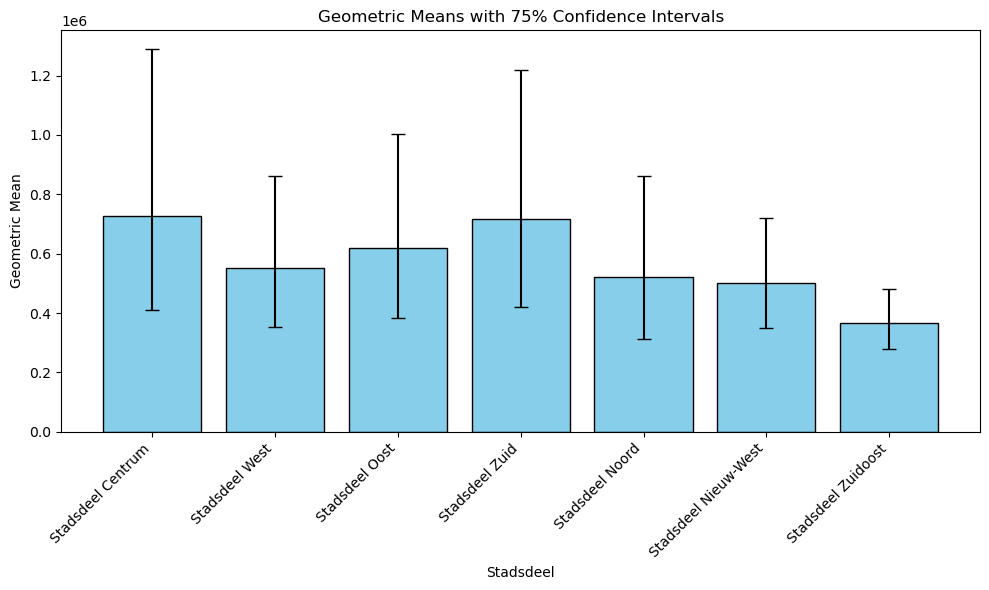

In [97]:
plot_geometric_means_with_ci(stadsdeel_stats, 'stadsdeel', 75, stadsdeel_order)

In [58]:
import pandas as pd
import numpy as np
import json

def generate_stadsdeel_subdivision_map(df):
    subdivision_stadsdeel_map = df[['stadsdeel','stadsdeel_onderverdeling']].drop_duplicates().set_index('stadsdeel_onderverdeling').to_dict('index')
    subdivion_stadsdeel_map = {s : subdivision_stadsdeel_map[s]['stadsdeel'] for s in subdivision_stadsdeel_map}
    return subdivion_stadsdeel_map

def process_data(df):
    df = df.copy()
    df = df.drop_duplicates()
    df = df[df['stadsdeel']!='Weesp']
    df['price_per_m2'] = df['price']/df['surface']
    df['price_per_room'] = df['price']/df['rooms']
    
    property_type_map = {
        'Appartement': 'Apartment',
        'Flat': 'Apartment',
        'Studio': 'Apartment',
        'House': 'House',
        'Huis': 'House',
        'Room': 'Room'
    }
    df['property_type'] = df['property_type'].map(property_type_map)
    
    furnished_map = {
        'Upholstered': 'Upholstered',
        'Furnished': 'Furnished',
        'Upholstered or furnished': 'Furnished',
        'Shell': 'Shell'
    }
    df.loc[df['post_type']=='Rent', 'furnished'] = df.loc[df['post_type']=='Rent', 'furnished'].map(furnished_map)
    
    return df
    
def remove_outliers(df, column_name, percentile_bounds):
    processed_df = df.copy()
    lower_bound = processed_df[column_name].quantile(percentile_bounds[0])
    upper_bound = processed_df[column_name].quantile(percentile_bounds[1])
    processed_df = processed_df[(
        (processed_df[column_name] >= lower_bound)&
        (processed_df[column_name] <= upper_bound)
    )]
    return processed_df

def compute_statistics(df, column_name, post_type, property_type, furnished, region_resolution, percentile_bounds, subdivion_stadsdeel_map):
    stats = []
    df_s = df.copy()
    df_s[f'log_{column_name}'] = np.log(df_s[column_name])
    df_s = df_s[df_s['post_type']==post_type]
    if property_type != 'All':
        df_s = df_s[df_s['property_type'] == property_type]
    if post_type == 'Rent':
        if furnished != 'All':
            df_s = df_s[df_s['furnished']==furnished]
    for region in df[region_resolution].unique():
        if region_resolution == 'stadsdeel':
            stadsdeel = region
            subdivision = None
        elif region_resolution == 'stadsdeel_onderverdeling':
            stadsdeel = subdivion_stadsdeel_map[region]
            subdivision = region
        df_r = df_s[df_s[region_resolution]==region]
        property_count = len(df_r)
        
        processed_df = remove_outliers(df_r, f'log_{column_name}', percentile_bounds)
        
        if len(processed_df) < 10:
            continue
        
        median = processed_df[column_name].median()
        q1 = processed_df[column_name].quantile(0.25)
        q3 = processed_df[column_name].quantile(0.75)
        mode = processed_df[column_name].mode().iloc[0]
        log_mean = processed_df[f'log_{column_name}'].mean()
        log_std = processed_df[f'log_{column_name}'].std()
        geometric_mean = np.exp(log_mean)
        geometric_std = np.exp(log_std)
        geometric_conf_int_95_low = np.exp(log_mean-1.96*log_std)
        geometric_conf_int_95_upp = np.exp(log_mean+1.96*log_std)
        geometric_conf_int_75_low = np.exp(log_mean-1.15*log_std)
        geometric_conf_int_75_upp = np.exp(log_mean+1.15*log_std)
        geometric_conf_int_50_low = np.exp(log_mean-0.674*log_std)
        geometric_conf_int_50_upp = np.exp(log_mean+0.674*log_std)
        stats.append({
            'region_resolution': region_resolution,
            'stadsdeel': stadsdeel,
            'subdivision': subdivision,
            'post_type': post_type,
            'property_type': property_type,
            'furnished': furnished,
            'value': column_name,
            'median': median,
            'q1': q1,
            'q3': q3,
            'mode': mode,
            'geometric_mean': geometric_mean,
            'geometric_std': geometric_std,
            'geometric_conf_int_95_low': geometric_conf_int_95_low,
            'geometric_conf_int_95_upp': geometric_conf_int_95_upp,
            'geometric_conf_int_75_low': geometric_conf_int_75_low,
            'geometric_conf_int_75_upp': geometric_conf_int_75_upp,
            'geometric_conf_int_50_low': geometric_conf_int_50_low,
            'geometric_conf_int_50_upp': geometric_conf_int_50_upp,
            'number_of_properties': property_count
        })
    stats_df = pd.DataFrame(stats)
    return stats_df

def run_stats_computation(df, percentile_bounds, subdivion_stadsdeel_map):
    stats_df = pd.DataFrame()
    for region_resolution in ['stadsdeel', 'stadsdeel_onderverdeling']:
        for post_type in ['Buy', 'Rent']:
            for property_type in ['All', 'Apartment', 'House']:
                for furnished in [None, 'All', 'Upholstered', 'Furnished', 'Shell']:
                    if post_type == 'Buy' and furnished is not None:
                        continue
                    elif post_type == 'Rent' and furnished is None:
                        continue
                    for column_name in ['price', 'surface', 'rooms', 'price_per_m2', 'price_per_room']:
                        s = compute_statistics(
                                df,  
                                column_name=column_name,
                                post_type=post_type,
                                property_type=property_type,
                                furnished = furnished,
                                region_resolution=region_resolution,
                                percentile_bounds=percentile_bounds,
                                subdivion_stadsdeel_map=subdivion_stadsdeel_map
                            )
                        
                        stats_df = pd.concat([stats_df,s])

    return stats_df

                        
def main():
    with open('config/stats_config.json', 'r') as f:
        stats_config = json.load(f)
    with open('config/bigquery_config.json', 'r') as f:
        bigquery_config = json.load(f)
    
    percentile_bounds = [stats_config['outliers_percentile_lower'], stats_config['outliers_percentile_upper']]
    
    df = pd.read_csv('data/data_19.csv')
    stadsdeel_subdivision_map = generate_stadsdeel_subdivision_map(df)
    processed_df = process_data(df)
    
    stats_df = run_stats_computation(processed_df, percentile_bounds, stadsdeel_subdivision_map)
    
    return stats_df


In [59]:
stats_df = main()

In [55]:
processed_df = process_data(df)

compute_statistics(processed_df, 
                   column_name='price', 
                   post_type='Buy', 
                   property_type='House', 
                   furnished=None, 
                   region_resolution='stadsdeel', 
                   percentile_bounds=percentile_bounds, 
                   subdivion_stadsdeel_map=subdivision_stadsdeel_map)

after filtering post type 2166
after filtering property type 287
after filtering furnished type 287
Stadsdeel West
Stadsdeel Nieuw-West
Stadsdeel Oost
Stadsdeel Zuid


,page_source,first_scrape_date,last_scrape_date,url,post_type,city,location,title,property_type,postcode,...,wijk,wijk_code,buurt,buurt_code,stadsdeel_onderverdeling,stadsdeel,pc6_jaar,price_per_m2,price_per_room,log_price
14,Pararius,2024-12-05,2024-12-16,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,NaN,Huis Willem Pijperstraat 66,House,1077 XM,...,Prinses Irenebuurt e.o.,WK0363KN,Prinses Irenebuurt,BU0363KN01,Buitenveldert / Zuidas,Stadsdeel Zuid,2024,9321.428571,261000.000000,14.264035
2006,Pararius,2024-12-05,2024-12-19,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,1075 CX Amsterdam (Willemspark),Huis Koninginneweg 14,House,1075 CX,...,Willemspark,WK0363KC,Willemsparkbuurt-Noord,BU0363KC02,Oud Zuid,Stadsdeel Zuid,2024,13333.333333,520000.000000,14.771022
2030,Pararius,2024-12-05,2024-12-16,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,NaN,Huis Van Breestraat 65,House,1071 ZG,...,Museumkwartier,WK0363KD,Concertgebouwbuurt,BU0363KD03,Oud Zuid,Stadsdeel Zuid,2024,12020.905923,383333.333333,15.053885
2084,Pararius,2024-12-05,2024-12-19,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,1071 GW Amsterdam (Museumkwartier),Huis Willemsparkweg 127,House,1071 GW,...,Museumkwartier,WK0363KD,Cornelis Schuytbuurt,BU0363KD02,Oud Zuid,Stadsdeel Zuid,2024,8803.526448,436875.000000,15.066844
2086,Pararius,2024-12-05,2024-12-19,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,1071 JL Amsterdam (Museumkwartier),Huis Cornelis Schuytstraat 62,House,1071 JL,...,Museumkwartier,WK0363KD,Banpleinbuurt,BU0363KD06,Oud Zuid,Stadsdeel Zuid,2024,10256.410256,311111.111111,14.845130
2087,Pararius,2024-12-05,2024-12-19,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,1071 SE Amsterdam (Museumkwartier),Huis Hacquartstraat 1,House,1071 SE,...,Museumkwartier,WK0363KD,Banpleinbuurt,BU0363KD06,Oud Zuid,Stadsdeel Zuid,2024,13571.428571,407142.857143,14.862830
2139,Pararius,2024-12-05,2024-12-16,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,NaN,Huis Tweede Jan Steenstraat 18 H,House,1073 VN,...,Oude Pijp,WK0363KE,Sarphatiparkbuurt,BU0363KE04,De Pijp / Rivierenbuurt,Stadsdeel Zuid,2024,7500.000000,250000.000000,14.626441
2540,Pararius,2024-12-05,2024-12-16,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,NaN,Huis Amstelveenseweg 1098,House,1081 JV,...,Buitenveldert-West,WK0363KQ,Buitenveldert-Zuidwest,BU0363KQ05,Buitenveldert / Zuidas,Stadsdeel Zuid,2024,6049.723757,136875.000000,13.906265
2541,Pararius,2024-12-05,2024-12-16,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,NaN,Huis Imstenrade 53,House,1082 AK,...,Buitenveldert-West,WK0363KQ,Buitenveldert-Zuid-Midden,BU0363KQ06,Buitenveldert / Zuidas,Stadsdeel Zuid,2024,6413.612565,204166.666667,14.018451
2563,Pararius,2024-12-05,2024-12-19,https://www.pararius.nl/huis-te-koop/amsterdam...,Buy,Amsterdam,1082 AK Amsterdam (Buitenveldert-West),Huis Imstenrade 49,House,1082 AK,...,Buitenveldert-West,WK0363KQ,Buitenveldert-Zuid-Midden,BU0363KQ06,Buitenveldert / Zuidas,Stadsdeel Zuid,2024,7798.165138,141666.666667,13.652992


In [60]:
stats_df[
    (stats_df['region_resolution']=='stadsdeel')&
    (stats_df['stadsdeel']=='Stadsdeel Zuid')&
    (stats_df['property_type']=='House')&
    (stats_df['post_type']=='Buy')
]

,region_resolution,stadsdeel,subdivision,post_type,property_type,furnished,value,median,q1,q3,mode,geometric_mean,geometric_std,geometric_conf_int_95_low,geometric_conf_int_95_upp,geometric_conf_int_75_low,geometric_conf_int_75_upp,geometric_conf_int_50_low,geometric_conf_int_50_upp,number_of_properties
3,stadsdeel,Stadsdeel Zuid,None,Buy,House,None,price,2.250000e+06,1.160000e+06,2.825000e+06,850000.000000,1.882845e+06,1.681661,679778.512331,5.215091e+06,1.035656e+06,3.423055e+06,1.326377e+06,2.672775e+06,13
3,stadsdeel,Stadsdeel Zuid,None,Buy,House,None,surface,1.950000e+02,1.745000e+02,2.800000e+02,109.000000,2.091944e+02,1.391576,109.465370,3.997821e+02,1.430597e+02,3.059024e+02,1.674274e+02,2.613808e+02,13
3,stadsdeel,Stadsdeel Zuid,None,Buy,House,None,rooms,7.000000e+00,6.000000e+00,8.250000e+00,6.000000,7.039739e+00,1.219458,4.771660,1.038589e+01,5.603568e+00,8.843994e+00,6.158573e+00,8.046982e+00,13
3,stadsdeel,Stadsdeel Zuid,None,Buy,House,None,price_per_m2,9.321429e+03,7.649083e+03,1.173079e+04,6396.341463,9.393646e+03,1.314640,5495.067768,1.605814e+04,6.858142e+03,1.286654e+04,7.811932e+03,1.129561e+04,13
3,stadsdeel,Stadsdeel Zuid,None,Buy,House,None,price_per_room,2.610000e+05,2.145833e+05,3.952381e+05,141666.666667,2.796779e+05,1.507070,125174.644777,6.248847e+05,1.745037e+05,4.482411e+05,2.121271e+05,3.687399e+05,13
